# Part II A: Data Cleaning and EDA on Subreddit - Depression_help

In [1]:
import numpy as np
import pandas as pd
import time
import re
import pickle

from wordcloud import WordCloud, STOPWORDS 

from sklearn.feature_extraction import stop_words

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords     # Import the stop word list

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading the data file

In [5]:
df = pd.read_csv('../data/depression_help.csv')
df.shape

(1241, 104)

data has 1241 entries and 104 columns

In [6]:
# Increase the number of columns in display
pd.set_option('display.max_columns', 110)

In [7]:
df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,media_metadata,name,quarantine,link_flair_text_color,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,author_cakeday
0,NaN,depression_help,&amp;#x200B;\n\nhttps://preview.redd.it/8akni1...,t2_xmlxk,False,NaN,0,False,Immediate Life Support - Discord Server,"[{'e': 'text', 't': 'ANNOUNCEMENT'}]",r/depression_help,False,NaN,NaN,0,False,"{'8akni1zthjs31': {'status': 'valid', 'e': 'Im...",t3_dhtwn3,False,dark,#ea0027,public,84,0,{},d330ba2e-1513-11e9-826a-0e6296dd7fa6,False,[],NaN,False,False,NaN,{},ANNOUNCEMENT,False,84,NaN,False,NaN,1571653567.0,NaN,"[{'e': 'text', 't': 'Moderator'}]",{},NaN,True,NaN,1.571103e+09,richtext,NaN,NaN,NaN,richtext,self.depression_help,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,485e3088-1514-11e9-8c5e-0e17d14364be,False,False,True,Moderator,False,NaN,NaN,moderator,t5_2zy2x,NaN,NaN,#ffd635,dhtwn3,True,NaN,TheRecruit4D,NaN,0,True,NaN,False,[],False,light,/r/depression_help/comments/dhtwn3/immediate_l...,NaN,True,https://www.reddit.com/r/depression_help/comme...,47163,1.571074e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,depression_help,I really don’t know... title says it all. I’m ...,t2_5f0c2d2h,False,NaN,0,False,I learned that 78% of suicides are men and peo...,"[{'e': 'text', 't': 'REQUESTING ADVICE'}]",r/depression_help,False,NaN,NaN,0,False,NaN,t3_etw82o,False,dark,NaN,public,152,0,{},NaN,False,[],NaN,False,False,NaN,{},REQUESTING ADVICE,False,152,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.580013e+09,richtext,NaN,NaN,NaN,text,self.depression_help,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,11a799da-1514-11e9-9dc7-0e1ca0773fda,False,False,False,NaN,False,NaN,NaN,NaN,t5_2zy2x,NaN,NaN,#94e044,etw82o,True,NaN,Depressed_Raichu,NaN,41,True,NaN,False,[],False,NaN,/r/depression_help/comments/etw82o/i_learned_t...,NaN,False,https://www.reddit.com/r/depression_help/comme...,47163,1.579985e+09,0,NaN,False,NaN,NaN,NaN
2,NaN,depression_help,"As I write this, reddit suggested me to add a ...",t2_4k8usfk9,False,NaN,0,False,Those dark days,"[{'e': 'text', 't': 'REQUESTING SUPPORT'}]",r/depression_help,False,NaN,NaN,0,True,NaN,t3_eu7h8f,False,dark,NaN,public,6,0,{},NaN,False,[],NaN,False,False,NaN,{},REQUESTING SUPPORT,False,6,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.580079e+09,richtext,NaN,NaN,NaN,text,self.depression_help,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,fe86abf2-1513-11e9-9dbf-0e34f9fee128,False,False,False,NaN,False,NaN,NaN,NaN,t5_2zy2x,NaN,NaN,#84e1dd,eu7h8f,True,NaN,lucchesi87,NaN,2,True,NaN,False,[],False,NaN,/r/depression_help/comments/

## 2. Data Cleaning

* `'title'`, `'selftext'` and `'subreddit'` are the columns that will be used for classification, but information from other columns are explored below to have a better understanding of the subreddit structure and contents

### Drop duplicate posts

In [8]:
df.drop_duplicates(subset=['title', 'selftext'], inplace=True)
df.shape

(989, 104)

The number of posts dropped form 1241 to 989.

### Missing entry in `title` and `selftext column`

In [9]:
df.title.isnull().sum()

0

In [10]:
df.selftext.isnull().sum()

99

In [11]:
# What're the posts that don't have selftext?
df[df.selftext.isnull()][['title','selftext']]

,title,selftext
5,What is going on here?,NaN
10,20 Surprising Things That Make People With Dep...,NaN
24,Depressed? ‘Exploratory study on the role of e...,NaN
53,Girlfriend couldn't cope with my depression an...,NaN
64,The dangers of depression NSFW,NaN
...,...,...
956,My kids got jokes,NaN
972,Sometimes you have to will yourself to have a ...,NaN
974,I'm super happy,NaN
976,Holidays are hard for me to,NaN


* 99 posts only contain  title, but no selftext.  
* As eventually these two columns will be combined into one single text, the nan will be replaced by a space.

In [12]:
# Capture the post index where selfttext is empty
index = list(df[df.selftext.isnull()][['title','selftext']].index)

In [13]:
df.loc[index][['title','selftext']]

,title,selftext
5,What is going on here?,NaN
10,20 Surprising Things That Make People With Dep...,NaN
24,Depressed? ‘Exploratory study on the role of e...,NaN
53,Girlfriend couldn't cope with my depression an...,NaN
64,The dangers of depression NSFW,NaN
...,...,...
956,My kids got jokes,NaN
972,Sometimes you have to will yourself to have a ...,NaN
974,I'm super happy,NaN
976,Holidays are hard for me to,NaN


#### Fill NaN with a space

In [14]:
df['selftext'].fillna(" ", inplace=True)

In [15]:
# To confirm anymore NaN in selftext
df.selftext.isnull().sum()

0

### Look at the column information

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 989
Columns: 104 entries, approved_at_utc to author_cakeday
dtypes: bool(26), float64(27), int64(8), object(43)
memory usage: 675.5+ KB


Data type: bool(26), float64(27), int64(8), object(43)

In [17]:
# Find columns that are all null
null_col = [col for col in df.columns if df[col].isnull().sum()==len(df)]
print(len(null_col))
null_col

25


['approved_at_utc',
 'mod_reason_title',
 'pwls',
 'link_flair_css_class',
 'category',
 'approved_by',
 'thumbnail',
 'author_flair_css_class',
 'content_categories',
 'mod_note',
 'wls',
 'removed_by_category',
 'banned_by',
 'likes',
 'suggested_sort',
 'banned_at_utc',
 'view_count',
 'removed_by',
 'num_reports',
 'mod_reason_by',
 'removal_reason',
 'report_reasons',
 'discussion_type',
 'whitelist_status',
 'parent_whitelist_status']

25 of out 43 Object columns are redundant, as all entries are null.

### Look at the numerical columns

In [18]:
df.describe()

,approved_at_utc,mod_reason_title,gilded,pwls,link_flair_css_class,downs,ups,total_awards_received,category,score,approved_by,thumbnail,author_flair_css_class,content_categories,mod_note,created,wls,removed_by_category,banned_by,likes,suggested_sort,banned_at_utc,view_count,removed_by,num_reports,mod_reason_by,removal_reason,report_reasons,discussion_type,num_comments,whitelist_status,parent_whitelist_status,subreddit_subscribers,created_utc,num_crossposts
count,0.0,0.0,989.000000,0.0,0.0,989.0,989.000000,989.000000,0.0,989.000000,0.0,0.0,0.0,0.0,0.0,9.890000e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,989.000000,0.0,0.0,989.000000,9.890000e+02,989.000000
mean,NaN,NaN,0.001011,NaN,NaN,0.0,11.247725,0.007078,NaN,11.247725,NaN,NaN,NaN,NaN,NaN,1.578672e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.706775,NaN,NaN,47163.721941,1.578643e+09,0.010111
std,NaN,NaN,0.031798,NaN,NaN,0.0,37.220515,0.083874,NaN,37.220515,NaN,NaN,NaN,NaN,NaN,8.285259e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.574315,NaN,NaN,0.448269,8.285259e+05,0.109742
min,NaN,NaN,0.000000,NaN,NaN,0.0,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.571103e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,47163.000000,1.571074e+09,0.000000
25%,NaN,NaN,0.000000,NaN,NaN,0.0,1.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.577985e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,47163.000000,1.577957e+09,0.000000
50%,NaN,NaN,0.000000,NaN,NaN,0.0,2.000000,0.000000,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,1.578660e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,47164.000000,1.578631e+09,0.000000
75%,NaN,NaN,0.000000,NaN,NaN,0.0,6.000000,0.000000,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,1.579365e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,47164.000000,1.579336e+09,0.000000
max,NaN,NaN,1.000000,NaN,NaN,0.0,665.000000,1.000000,NaN,665.000000,NaN,NaN,NaN,NaN,NaN,1.580083e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,NaN,NaN,47164.000000,1.580055e+09,2.000000


* Most of the numeric cols have no data (count=0, NaN in all statistics)
* Potential meaningful columns are: `ups`, `created`, `created_utc`, `num_comments`, `num_crossposts`.  They were explored below.

In [19]:
# Create a subset of the df based on interested columns
df[['subreddit','title','selftext','ups','score','num_comments','created','created_utc','num_crossposts','crosspost_parent', 'crosspost_parent_list','is_video','media']].head()

,subreddit,title,selftext,ups,score,num_comments,created,created_utc,num_crossposts,crosspost_parent,crosspost_parent_list,is_video,media
0,depression_help,Immediate Life Support - Discord Server,&amp;#x200B;\n\nhttps://preview.redd.it/8akni1...,84,84,0,1.571103e+09,1.571074e+09,0,NaN,NaN,False,NaN
1,depression_help,I learned that 78% of suicides are men and peo...,I really don’t know... title says it all. I’m ...,152,152,41,1.580013e+09,1.579985e+09,0,NaN,NaN,False,NaN
2,depression_help,Those dark days,"As I write this, reddit suggested me to add a ...",6,6,2,1.580079e+09,1.580050e+09,0,NaN,NaN,False,NaN
3,depression_help,There's nothing interesting to title this,"I feel inferior to others, especially my crush...",2,2,1,1.580083e+09,1.580055e+09,0,NaN,NaN,False,NaN
4,depression_help,School instantly destroys my mental state,I struggle with mental health no matter what I...,27,27,5,1.580031e+09,1.580002e+09,0,NaN,NaN,False,NaN


In [20]:
df[df.ups != df.score]

# observation: ups and score means the same thing for the data collected

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,media_metadata,name,quarantine,link_flair_text_color,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,author_cakeday


### When are the messages posted?

* There are 2 columns for time: `created` and `created_utc` 
* Columns `created` and `created_utc` are unix epoch time.  It is the number of seconds that have elapsed since the Unix epoch, that is the time 00:00:00 UTC on 1 January 1970, minus leap seconds.
* `created_utc`: unix time which is in UTC and local unix time - convert this to human readable time

In [21]:
df['created'].map(lambda x:time.ctime(x))

0      Tue Oct 15 09:29:33 2019
1      Sun Jan 26 12:37:41 2020
2      Mon Jan 27 06:42:00 2020
3      Mon Jan 27 08:04:38 2020
4      Sun Jan 26 17:27:11 2020
                 ...           
985    Wed Dec 25 17:28:03 2019
986    Wed Dec 25 16:46:10 2019
987    Wed Dec 25 09:09:55 2019
988    Wed Dec 25 05:36:39 2019
989    Wed Dec 25 10:18:44 2019
Name: created, Length: 989, dtype: object

In [22]:
# Create a column of human - readable time
df['created_time'] = df['created_utc'].map(lambda x:time.ctime(x))

In [23]:
df['created_time'].min(), df['created_time'].max()

('Fri Dec 27 01:29:30 2019', 'Wed Jan 22 23:54:59 2020')

The message was posted between Dec 27 2019 to Jan 22 2020

In [24]:
df.loc[727][['title','created_time']]

title           The holiday season can be hard, sometimes a na...
created_time                             Thu Jan  2 04:06:36 2020
Name: 727, dtype: object

Used post #727 to verify with the website that created_utc coresponds to the time that we see on the webiste posts (Singapore local time).

### Explore the potential columns that help to clean the data
#### 2.1 Remove moderator's messages

In [25]:
df.author_flair_text.astype(str).value_counts()

nan          987
Moderator      2
Name: author_flair_text, dtype: int64

In [26]:
df.distinguished.astype(str).value_counts()

nan          988
moderator      1
Name: distinguished, dtype: int64

In [27]:
df.stickied.value_counts()

False    988
True       1
Name: stickied, dtype: int64

In [28]:
df[df.author_flair_text.notnull()][['title', 'selftext','author', 'author_fullname','distinguished','stickied','author_flair_text']]

,title,selftext,author,author_fullname,distinguished,stickied,author_flair_text
0,Immediate Life Support - Discord Server,&amp;#x200B;\n\nhttps://preview.redd.it/8akni1...,TheRecruit4D,t2_xmlxk,moderator,True,Moderator
727,"The holiday season can be hard, sometimes a na...",,XxpillowprincessxX,t2_lhufk18,NaN,False,Moderator


In [29]:
df.loc[0]['selftext']

'&amp;#x200B;\n\nhttps://preview.redd.it/8akni1zthjs31.jpg?width=840&amp;format=pjpg&amp;auto=webp&amp;s=7acbfa2b903ba415b333bc01ece2ca02b77efa66\n\nExperiencing or relate to any of the above? Do you wish to speak to people in a safe, well-moderated online community? [Our Discord server](https://discord.gg/JTGxsjb) offers 1:1 support, off-topic channels to talk with AMAZING people, and chats for mental health.'

In [30]:
df.loc[727][['title','selftext']]

title       The holiday season can be hard, sometimes a na...
selftext                                                     
Name: 727, dtype: object

In [31]:
# Verified with the website that the above entries came from moderators
# Remove them.
df.drop(labels=[0,727], inplace=True)

# verify it's removed
#df.loc[727]  

### Post Categories: not all posts are from help seekers (see below  cells)
* There are posts seeking help
* There are posts providing helps/advice
* **Mis-categorized occurred (people asking for help, but posted under PROVIDING SUPPORT, vice versa)
* After inspecting the different categories, will group NaN, RANT, OTHER and STORY posts as REQUESTING ADVICE/SUPPORT, 
*  That means about 10% of the posts (PROVIDING SUPPORT, PROVIDING ADVICE, INSPIRATION, MOVTIVATION, etc) will be removed for classification.  This is a big amount of posts to remove, but is necessary.

In [32]:
df.link_flair_text.astype(str).value_counts()

REQUESTING ADVICE                  388
REQUESTING SUPPORT                 227
nan                                117
RANT                                91
OTHER                               32
STORY                               32
PROVIDING SUPPORT                   28
PROVIDING ADVICE                    24
INSPIRATION                         23
MOTIVATION                          21
STORY/ADVICE/MOTIVATION              1
uni gives me the heevie jeebies      1
is this normal                       1
OTHER - CALL FOR RESOURCES?          1
Name: link_flair_text, dtype: int64

In [33]:
df.link_flair_text.astype(str).value_counts(normalize=True)

REQUESTING ADVICE                  0.393110
REQUESTING SUPPORT                 0.229990
nan                                0.118541
RANT                               0.092199
OTHER                              0.032421
STORY                              0.032421
PROVIDING SUPPORT                  0.028369
PROVIDING ADVICE                   0.024316
INSPIRATION                        0.023303
MOTIVATION                         0.021277
STORY/ADVICE/MOTIVATION            0.001013
uni gives me the heevie jeebies    0.001013
is this normal                     0.001013
OTHER - CALL FOR RESOURCES?        0.001013
Name: link_flair_text, dtype: float64

In [34]:
df[df.link_flair_text == 'PROVIDING SUPPORT'][['title','selftext', 'link_flair_text']].head()

,title,selftext,link_flair_text
21,Help I don't know what to do,I have 2 semesters left in college and I've be...,PROVIDING SUPPORT
68,Anyone if anyone is suffering from depression ...,,PROVIDING SUPPORT
99,Suicidal thoughts? ** PLEASE WATCH THIS VIDEO ...,,PROVIDING SUPPORT
118,Tips to Cope with Depression: A Novice's Guide...,For context I'm a 25F in a highly developed ci...,PROVIDING SUPPORT
151,A community for us,Hey guys you may have seen posts from me befor...,PROVIDING SUPPORT


In [35]:
df.loc[21,'selftext']

"I have 2 semesters left in college and I've been married for 5 months. This is the first time I've lived outside of a busy household. My husband works out of town for the week and comes home on the weekend. I am a theatre major who works two jobs and I feel overwhelmed constantly with school. I don't feel good enough or like I want to finish. I have a hard time cleaning and keeping my space organized which I feel bad about when my husband comes home cause he's been gone and I've missed him and I want to make him happy. I feel bad putting this stuff on him cause he has also suffered from depression. I was cutting myself a few months ago but I stopped cause I felt ashamed, instead I've chopped all my hair off which is kinda nice cause I get a lot of compliments. I feel useless and dumb and like I don't need to exist. I don't want to get help cause I am on my parents insurance and I don't want them to know I am depressed. I also just feel ashamed that I might need help. Life feels so dar

#### NaN rows
* Treat nan rows as REQUESTING ADVICE/SUPPORT
* 145 and 158 are duplicate posts

In [36]:
df[df.link_flair_text.isnull()][['title','selftext', 'link_flair_text']].head(20)

,title,selftext,link_flair_text
45,Hopeless.,I can’t seem to cope with my feelings anymore....,NaN
60,help,I don’t know what to say... I keep seeing her ...,NaN
66,I feel like I'm slipping into a void. Again.,"I felt like hanging myself this morning, the o...",NaN
77,Music Therapy,Please take my Music Therapy survey! I need re...,NaN
108,Depressed personality traits,"For me, whats almost worth than the depression...",NaN
119,Do you ever think suicide will ever be acceptable,As in will it ever be an option. An easier opt...,NaN
125,Starting a community art gallery,Trying to start a support visual gallery\n\nHe...,NaN
135,My roommate won’t let me sleep,I’m a first year college student in the univer...,NaN
145,Music Therapy,Please take my Music Therapy survey! I need re...,NaN
154,So sad,Just need someone to talk to tbh. Even if it’s...,NaN


In [37]:
df.loc[145]['selftext']

'Please take my Music Therapy survey! I need responses for my AP Research class. Also if you know anyone who’s also willing to take this survey, it will be greatly appreciated.\nhttps://docs.google.com/forms/d/e/1FAIpQLSdeWQZjwM75JCxIbkM9q2hEFmTbhxGUIgGoaL0OgPxP9hXMOA/viewform?usp=sf_link'

In [38]:
df.loc[158]['selftext']

'Please take my Music Therapy Survey! I need responses for my AP Research class. Also if you know anyone who is willing to do it, it would be greatly appreciated.\nhttps://docs.google.com/forms/d/e/1FAIpQLSdeWQZjwM75JCxIbkM9q2hEFmTbhxGUIgGoaL0OgPxP9hXMOA/viewform?usp=sf_link'

#### RANT rows

In [39]:
df[df.link_flair_text == 'RANT'][['title','selftext', 'link_flair_text']].head()

,title,selftext,link_flair_text
46,Im so pissed and sad,"Recently, my sister got blocked by all her fri...",RANT
50,Emotional Hangovers,"That period after an exciting or fun event, th...",RANT
80,I don’t know my place anymore,Lately I feel like a background character to e...,RANT
87,(nsfw) I’m just so tired.,I want to die. But I’m a coward. I have no dir...,RANT
90,I'm pretty sure i could leave at this point an...,"Im pretty social, but the last year has been t...",RANT


#### PROVIDING ADVICE rows

In [40]:
df[df.link_flair_text == 'PROVIDING ADVICE'][['title','selftext', 'link_flair_text']].head()

,title,selftext,link_flair_text
78,GIVE YOURSELF A PAT ON THE BACK! 👍,,PROVIDING ADVICE
95,If you're scared of meds (effexor/venlafaxine),,PROVIDING ADVICE
148,Please make it stop,I hate sleeping cause Everytime I dream I have...,PROVIDING ADVICE
174,I hope this is helpful for someone,Therapist of 22 years here. I've been reading ...,PROVIDING ADVICE
226,If any of you fuckers think someone is faking ...,People at my school go around saying people li...,PROVIDING ADVICE


In [41]:
df.loc[226]['selftext']

'People at my school go around saying people like me are “faking depression” because it’s the “cool new thing”. Nobody wants to be depressed you fuckin dick heads. All you cunts are doing when you tell them that they’re faking it is increasing the chances they are just gonna tie a noose in their basement and hand themselves. So fuckin stop if you do that\n\nThis is a rant/providing advice'

#### STORY and OTHER rows
* There is a mixture of help seeking and none-help seeking posts, but most of the posts are help seeking.
* Consider them as help seeking posts

In [42]:
# show the first 20 STORY or OTHER posts
df[(df.link_flair_text == 'OTHER') |(df.link_flair_text == 'STORY')][['title','selftext', 'link_flair_text']].head(20)

,title,selftext,link_flair_text
11,I'm not good with titles,Everyone today is my grandmothers birthday and...,STORY
14,#currentmanicstate,"Current manic state: Halsey, dying my hair and...",STORY
24,Depressed? ‘Exploratory study on the role of e...,,OTHER
28,PBA and Multi Personality Disorder,Please I think i need help i have multiple per...,OTHER
32,I don't know anymore,"Highschool has been rough for me, but this sch...",STORY
41,Fight to stay active,"Trust me, I'm not technically qualified to giv...",STORY
79,"I actually sobbed while in the shower, I think...","I don't know why I'm writing this, this is my ...",STORY
111,Thick thighs and heavy sighs,My first post. \nI am incredibly depressed and...,STORY
113,How we dealt with depression.. And how it was ...,Disclaimer: I'm posting this for a friend who ...,STORY
141,What are the new treatment modalities in depre...,,OTHER


In [43]:
# Look at one of the STORY post
df.loc[303]['selftext']

'I’m a 23 year old male who was diagnosed with major depressive disorder and anxiety a couple of years ago., and recently I was diagnosed with panic disorder. I’ve been on medication for quite some time now and I’ve been able to manage things up until late. I’ve been working for this big company for about 4 months now and had nothing but good experiences throughout.\n\nLast week I experienced my first panic attack. It was a ride. These attacks went on for days. And once I was able to see my doctor we found out that I had panic disorder, and that my depression and anxiety were contributing to the development of this new disorder. We discussed what I’ve been experiencing and she advised me to resign from work. I decided not to do that and try to work on and power through it, but it only made things worse. \n\nFast forward to today, I decided to resign from my company because my conditions were getting in the way of me being able to do the work that was expected of me, and it’s been takin

#### Remove posts that are not seeking seeking help

In [44]:
df = df[(df.link_flair_text == 'REQUESTING ADVICE')|
        (df.link_flair_text == 'REQUESTING SUPPORT')|
        (df.link_flair_text.isnull())|
        (df.link_flair_text == 'RANT')|
        (df.link_flair_text == 'OTHER')|
        (df.link_flair_text == 'STORY')]
df.shape

(887, 105)

### Crossposts
Summary:
* 3 columns were looked into: num_crossposts, crosspost_parent_list and crosspost_parent
* num_crossposts is to track the number of posts that get posted again.
* crosspost_parent_list and crosspost_parent are the ones that indicate if a post is a crosspost - remove these posts to avoid duplicates

In [45]:
df.num_crossposts.value_counts()

0    880
1      7
Name: num_crossposts, dtype: int64

In [46]:
df[df.num_crossposts != 0]

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,media_metadata,name,quarantine,link_flair_text_color,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,link_flair_template_id,can_gild,spoiler,locked,author_flair_text,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,author_cakeday,created_time
34,NaN,depression_help,"After almost a decade of therapy and meds, I’m...",t2_5hva79jt,False,NaN,0,False,Alternative Treatments?,"[{'e': 'text', 't': 'REQUESTING SUPPORT'}]",r/depression_help,False,NaN,NaN,0,False,NaN,t3_etli9u,False,dark,NaN,public,3,0,{},NaN,False,[],NaN,False,False,NaN,{},REQUESTING SUPPORT,False,3,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.579952e+09,richtext,NaN,NaN,NaN,text,self.depression_help,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,fe86abf2-1513-11e9-9dbf-0e34f9fee128,False,False,False,NaN,False,NaN,NaN,NaN,t5_2zy2x,NaN,NaN,#84e1dd,etli9u,True,NaN,crazyckava,NaN,6,True,NaN,False,[],False,NaN,/r/depression_help/comments/etli9u/alternative...,NaN,False,https://www.reddit.com/r/depression_help/comme...,47163,1.579923e+09,1,NaN,False,NaN,NaN,NaN,Sat Jan 25 11:31:17 2020
57,NaN,depression_help,my birthday is in a couple of days and I’ve be...,t2_4jk5nytf,False,NaN,0,False,I’m just sad,"[{'e': 'text', 't': 'REQUESTING SUPPORT'}]",r/depression_help,False,NaN,NaN,0,False,NaN,t3_et2ja9,False,dark,NaN,public,9,0,{},NaN,False,[],NaN,False,False,NaN,{},REQUESTING SUPPORT,False,9,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.579856e+09,richtext,NaN,NaN,NaN,text,self.depression_help,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,fe86abf2-1513-11e9-9dbf-0e34f9fee128,False,False,False,NaN,False,NaN,NaN,NaN,t5_2zy2x,NaN,NaN,#84e1dd,et2ja9,True,NaN,youredoingamzgsweeti,NaN,6,True,NaN,False,[],False,NaN,/r/depression_help/comments/et2ja9/im_just_sad/,NaN,False,https://www.reddit.com/r/depression_help/comme...,47163,1.579827e+09,1,NaN,False,NaN,NaN,NaN,Fri Jan 24 08:45:23 2020
144,NaN,depression_help,I should be over the moon. I should be extreme...,t2_353wye46,False,NaN,0,False,Continuous circle.,"[{'e': 'text', 't': 'REQUESTING ADVICE'}]",r/depression_help,False,NaN,NaN,0,False,NaN,t3_es022l,False,dark,NaN,public,6,0,{},NaN,False,[],NaN,False,False,NaN,{},REQUESTING ADVICE,False,6,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.579665e+09,richtext,NaN,NaN,NaN,text,self.depression_help,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,True,False,False,False,[],[],False,11a799da-1514-11e9-9dc7-0e1ca0773fda,False,False,False,NaN,False,NaN,NaN,NaN,t5_2zy2x,NaN,NaN,#94e044,es022l,True,NaN,9-11wasamyth,NaN,3,True,NaN,False,[],False,NaN,/r/depression_help/comments/es022l/continuous_...,NaN,False,https://www.reddit.com/r/depression_help/comme...,47163,1.579637e+09,1,NaN,False,N

In [47]:
df.loc[34]['permalink']

'/r/depression_help/comments/etli9u/alternative_treatments/'

* Permalink was verified on the website, from what is seen `num_crossposts` is to track the number of posts that get posted again in another subreddit.

In [48]:
print(df[df['crosspost_parent_list'].notnull()].shape)
print(df[df['crosspost_parent'].notnull()].shape)

(13, 105)
(13, 105)


In [49]:
df[(df['crosspost_parent'].notnull())&(df['crosspost_parent_list'].notnull())].shape

(13, 105)

* Confirmed that if `crosspost_parent` of a post is not null,  `crosspost_parent_list` is not null either.
* 22 posts in total.

In [50]:
df.loc[53]['crosspost_parent_list']

'[{\'approved_at_utc\': None, \'subreddit\': \'depression\', \'selftext\': "Literally broke up with me yesterday, we\'re both in shambles over it. She was the one to get me to admit to my decade long depression and kept trying to motivate me. I\'ve been halfassing attempts at leading a normal life with her for 2 years, but I kept sinking back into it, doing nothing all day, not entertaining her or me, killing my sexdrive with masturbation and playing videogames without joy.\\n\\nLast sunday she told me there was a person at her university that she liked and who radiates all the things I am not: is generally happy, talkative, travels and shares her interests. I feel so shitty for this, but I immediatly picked up my slack. Made an appointment with a psychotherapist, started running errands I have avoided for ages, went to sign up for sports and was trying to keep myself busy. I thought I could turn this around at the last second, show her that I care and that I want to change. She ended 

* `crosspost_parent_list` shows the original post. Confirmed that the these posts are cross-posts

#### Remove Crossposts

In [51]:
df = df[df['crosspost_parent'].isnull()]
df.shape

(874, 105)

887 - 13 = 874

### Whare are the video and media posts?

In [52]:
df.is_video.value_counts()

False    868
True       6
Name: is_video, dtype: int64

In [53]:
df.media.astype(str).value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             862
{'type': 'youtube.com', 'oembed': {'provider_url': 'https://www.youtube.com/', 'version': '1.0', 'title': 'Holy Darkness', 'type': 'video', 'thumbnail_width': 480, 'height': 344, 'width': 459, 'html': '&lt;iframe width="459" height="344" src="https://www.youtube.com/embed/R0K

In [54]:
df[df['is_video'] == True]['media']

327    {'reddit_video': {'fallback_url': 'https://v.r...
469    {'reddit_video': {'fallback_url': 'https://v.r...
489    {'reddit_video': {'fallback_url': 'https://v.r...
956    {'reddit_video': {'fallback_url': 'https://v.r...
976    {'reddit_video': {'fallback_url': 'https://v.r...
988    {'reddit_video': {'fallback_url': 'https://v.r...
Name: media, dtype: object

In [55]:
df[df['media'].notnull()]['media']

243    {'type': 'youtube.com', 'oembed': {'provider_u...
300    {'type': 'youtube.com', 'oembed': {'provider_u...
311    {'oembed': {'provider_url': 'https://www.youtu...
327    {'reddit_video': {'fallback_url': 'https://v.r...
469    {'reddit_video': {'fallback_url': 'https://v.r...
489    {'reddit_video': {'fallback_url': 'https://v.r...
609    {'type': 'youtube.com', 'oembed': {'provider_u...
815    {'type': 'youtube.com', 'oembed': {'provider_u...
822    {'type': 'youtube.com', 'oembed': {'provider_u...
956    {'reddit_video': {'fallback_url': 'https://v.r...
976    {'reddit_video': {'fallback_url': 'https://v.r...
988    {'reddit_video': {'fallback_url': 'https://v.r...
Name: media, dtype: object

In [56]:
df.iloc[469]['selftext']

'I just realized that I have been totally wound up and stressed for the past few days without even realizing and have had trouble sleeping because of it. My mind and body both feel super tight and I can’t seem to relax enough to be calm/ feel less pressure. I don’t have anything in particular stressing me so do you guys have a way to let go? Or unwind your head a little? Thank you'

`is_video` is a subset of `media`, there are 12 media files, and it seems that the media link is store inside `media` column.   `title` and `selftext` columns do not contain the url, so cleaning of these 12 posts is not needed

### Save the cleaned data

In [57]:
df.shape

(874, 105)

In [58]:
df.to_csv('../data/depression_cleaned.csv')

### What's the most frequently used word in the subreddit?

#### plot word cloud for selftext

In [59]:
text = " ".join(str(msg) for msg in df.selftext)
print (f"There are {len(text)} words in the combination of all {len(df.selftext)} review.")

There are 966168 words in the combination of all 874 review.


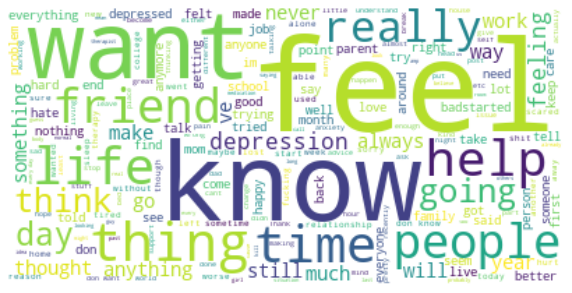

In [60]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["even", "now", 'one'])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../images/dh_selftext_wordcloud.png')

Words "feel", "know", "life", "help" "thing", "time" are most mentioned in subtext

#### Plot wordcloud for title

In [61]:
text = " ".join(str(msg) for msg in df.title)
print (f"There are {len(text)} words in the combination of all {len(df.title)} review.")

There are 40193 words in the combination of all 874 review.


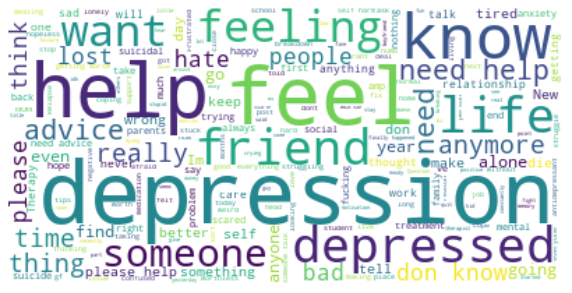

In [62]:
# Create stopword list:
#stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../images/dh_title_wordcloud.png')

Words "depression", "help", "depressed", "feel", "life" are most mentioned in title

## 3. Combine title and selftext into one text

In [63]:
df['comtext'] = df['title'] + " " + df['selftext']
df['comtext'].isnull().sum()

0

In [64]:
# Check if the combined text is done properly with a post
df['comtext'].loc[1]

'I learned that 78% of suicides are men and people who’ve self harmed are 9 times more likely to commit suicide. I’m worried about myself I really don’t know... title says it all. I’m worried I’ll go completely under with no one there for me and lose control of myself'

In [65]:
df.loc[1]['title']

'I learned that 78% of suicides are men and people who’ve self harmed are 9 times more likely to commit suicide. I’m worried about myself'

In [66]:
df.loc[1]['selftext']

'I really don’t know... title says it all. I’m worried I’ll go completely under with no one there for me and lose control of myself'

#### Plot word cloud for comtext

In [67]:
text = " ".join(str(msg) for msg in df.comtext)
print (f"There are {len(text)} words in the combination of all {len(df.comtext)} review.")

There are 1006362 words in the combination of all 874 review.


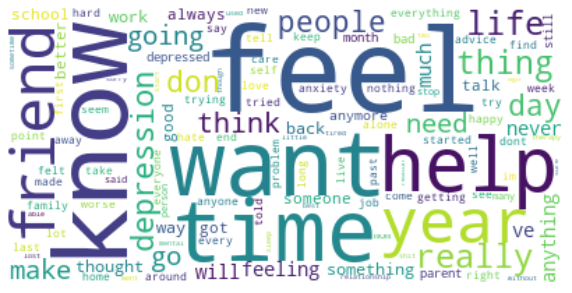

In [68]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["even", "now", 'one'])

# Generate a word cloud image
wordcloud = WordCloud(collocations=False,max_words=120,background_color="white", stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../images/dh_combined_wordcloud.png')

Words "feel", "want", "know", "life", "thing"

## 4. Create a dataframe that contains only the info needed for classification

In [69]:
df_depression = df[['subreddit','comtext']]
df_depression

,subreddit,comtext
1,depression_help,I learned that 78% of suicides are men and peo...
2,depression_help,"Those dark days As I write this, reddit sugges..."
3,depression_help,There's nothing interesting to title this I fe...
4,depression_help,School instantly destroys my mental state I st...
6,depression_help,Yeeeah first shower in...a long time! Yeeeah f...
...,...,...
984,depression_help,Plz help I haven’t had the best Christmas so f...
985,depression_help,I have a thought of killing myself daily I’m l...
986,depression_help,am i having anxiety attack? hope this is the r...
988,depression_help,I hate shopping


### Pickle the df

In [70]:
filename = '../data/pickled_depression.csv'
pickle.dump(df_depression, open(filename, 'wb'))